In [1]:
from src.model import VAE
from src.trainer import CLEARVAETrainer, MLVAETrainer
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [4]:
np.random.seed(101)
torch.manual_seed(101)

In [5]:
from src.utils import StyledMNISTGenerator, StyledMNIST

generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:17<00:00, 3361.82item/s]


In [6]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [1e2, 1e2]
LABEL_FLIPPING = True

clear_vae = VAE(total_z_dim=Z_DIM).to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(clear_vae.parameters(), lr=1e-3)
clear_trainer = CLEARVAETrainer(
    clear_vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [7]:
clear_trainer.fit(31, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 98.71it/s] 


val_recontr_loss=51.609, val_kl_c=13.914, val_kl_s=15.904, val_c_loss=0.223, val_s_loss=0.112
gMIG: 0.209; elbo: -81.427


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 234.14it/s]


val_recontr_loss=26.095, val_kl_c=13.930, val_kl_s=20.082, val_c_loss=0.105, val_s_loss=0.110
gMIG: 0.265; elbo: -60.107


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 208.35it/s]


val_recontr_loss=22.068, val_kl_c=14.417, val_kl_s=19.798, val_c_loss=0.100, val_s_loss=0.109
gMIG: 0.281; elbo: -56.282


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 227.26it/s]


val_recontr_loss=20.000, val_kl_c=14.906, val_kl_s=20.589, val_c_loss=0.101, val_s_loss=0.109
gMIG: 0.282; elbo: -55.495


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 234.87it/s]


val_recontr_loss=18.804, val_kl_c=15.494, val_kl_s=20.514, val_c_loss=0.088, val_s_loss=0.111
gMIG: 0.287; elbo: -54.812


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 233.67it/s]


val_recontr_loss=17.541, val_kl_c=16.248, val_kl_s=21.292, val_c_loss=0.090, val_s_loss=0.109
gMIG: 0.286; elbo: -55.081


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 221.75it/s]


val_recontr_loss=16.610, val_kl_c=15.951, val_kl_s=20.893, val_c_loss=0.078, val_s_loss=0.109
gMIG: 0.295; elbo: -53.454


In [8]:
Z_DIM = 16

ml_vae = VAE(total_z_dim=Z_DIM).to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(ml_vae.parameters(), lr=1e-3)
ml_trainer = MLVAETrainer(
    ml_vae,
    optimizer,
    hyperparameter={"beta": 1 / 8, "loc": 0, "scale": 1},
    verbose_period=5,
    device=device,
)

In [9]:
ml_trainer.fit(31, train_loader, valid_loader, with_evidence_acc=True)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 107.57it/s]


val_recontr_loss=53.323, val_kl_c=19.738, val_kl_s=14.775
gMIG: 0.405; elbo: -87.837


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 103.72it/s]


val_recontr_loss=25.968, val_kl_c=20.013, val_kl_s=17.223
gMIG: 0.482; elbo: -63.204


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 108.79it/s]


val_recontr_loss=22.654, val_kl_c=20.989, val_kl_s=18.661
gMIG: 0.503; elbo: -62.304


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 112.23it/s]


val_recontr_loss=20.822, val_kl_c=22.287, val_kl_s=19.240
gMIG: 0.52; elbo: -62.348


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 108.61it/s]


val_recontr_loss=20.351, val_kl_c=21.529, val_kl_s=19.582
gMIG: 0.521; elbo: -61.462


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 108.12it/s]


val_recontr_loss=19.528, val_kl_c=21.240, val_kl_s=19.415
gMIG: 0.524; elbo: -60.183


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 101.62it/s]


val_recontr_loss=18.961, val_kl_c=21.606, val_kl_s=19.804
gMIG: 0.536; elbo: -60.371


In [10]:
from expr.visual_utils import feature_swapping_plot, interpolation_plot

### clear-vae

In [113]:
torch.manual_seed(111)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
clear_vae.eval()
X_hat, latent_params, z = clear_vae(X.clone(), explicit=True)


In [114]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

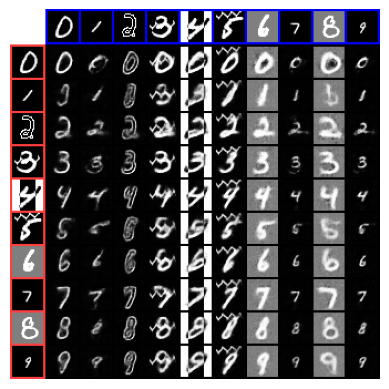

In [115]:
# illustration using all c
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], clear_vae)


In [116]:
# illustration using all s
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape

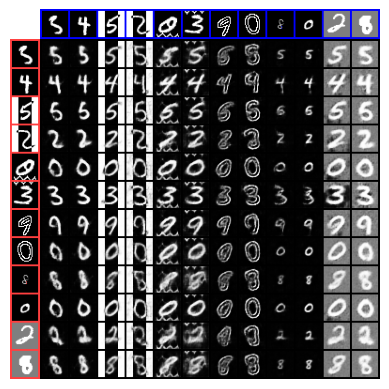

In [117]:
feature_swapping_plot(z_c, z_s, X[img_idx], clear_vae)

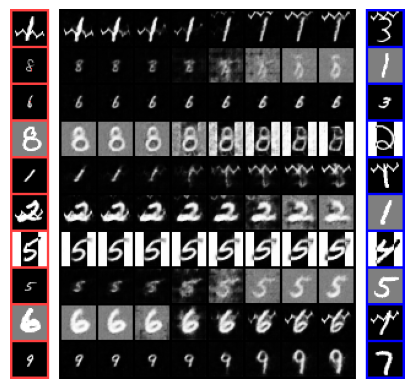

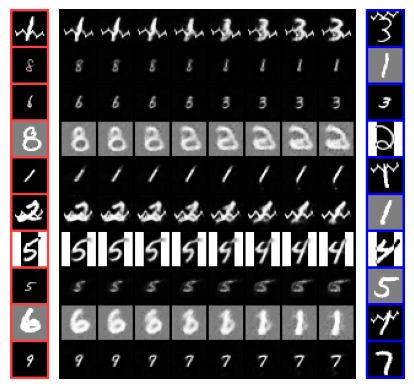

In [118]:
torch.manual_seed(1111)
np.random.seed(1111)
interpolation_plot(X, z, clear_vae, int(Z_DIM / 2), inter_steps=8)

### ml-vae

In [119]:
torch.manual_seed(111)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
ml_vae.eval()
X_hat_acc, latent_params_acc, z_acc = ml_vae(X.clone(), explicit=True)
X_hat_nacc, latent_params_nacc, z_nacc = ml_vae(X.clone(), c, explicit=True)

In [120]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

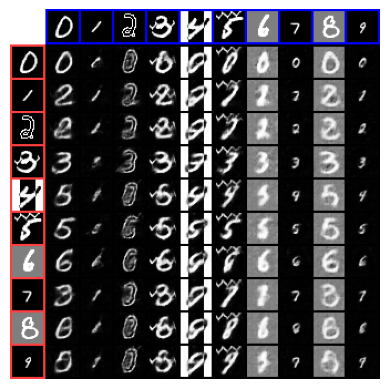

In [121]:
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], ml_vae)

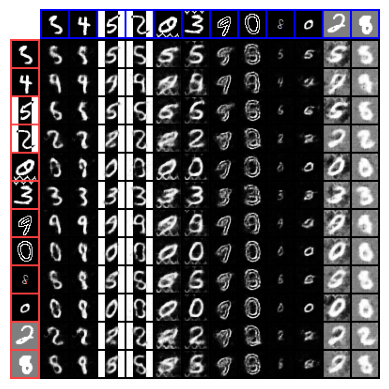

In [122]:
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], ml_vae)

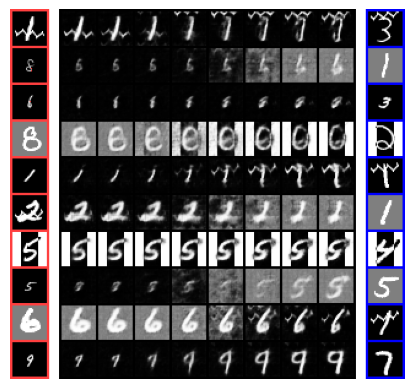

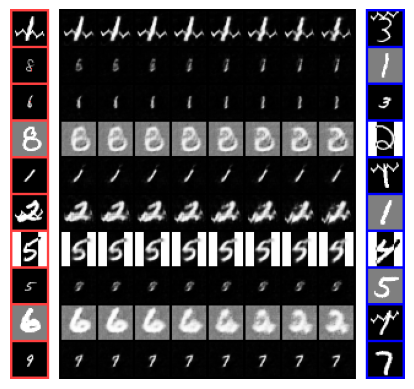

In [123]:
torch.manual_seed(1111)
np.random.seed(1111)
interpolation_plot(X, z_acc, ml_vae, int(Z_DIM / 2), inter_steps=8)